<details>
   <summary>Metadata</summary> 
    title: "E-TRAINEE Research-oriented case study: Time series-based change analysis of sandy beach dynamics"<br>
    description: "This is the sixth theme within the 3D/4D Geographic Point Cloud Time Series Analysis module."<br>
    dateCreated: 2023-03<br>
    authors: Katharina Anders, Bernhard Höfle<br>
    contributors: Sina Zumstein<br>
    estimatedTime: 1.5 hrs<br>
</details>

# Case study: Time series-based change analysis of sandy beach dynamics

Observation of beach dynamics using near-continuous laser scanning provides insight on surface processes that occur on a large range of spatiotemporal scales. Sandy beaches are highly complex in their morphodynamics, and constantly changing their shape due to sand transport through wind and wave action. Further, use of beaches through humans (for leisure) and measures against, e.g., coastal erosion, lead to anthropogenic modifications, which overlap and interact with natural processes.

In this case study, an hourly time series of point clouds acquired by permanent terrestrial laser scanning (TLS) is used to assess surface dynamics on a sandy beach.

The objective is to learn about 
* <a href="#getting-started-with-the-data">Getting started with the data (interactive session)</a>
* <a href="#environmental-influences-on-the-3d-time-series">Environmental influences on the 3D time series and information extraction</a>
* <a href="#volume-change-observation-depending-on-acquisition">Volume change observation depending on acquisition frequency</a>
* <a href="#analysis-of-coastal-dynamics-with-time-series-based-change-analysis">Analysis of coastal dynamics with time series-based change analysis</a>
* <a href="#variation-of-beach-width">Variation of beach width (Noordwijk)</a>
* <a href="#spatiotemporal-variation-of-surface-moisture-on-the-beach">Spatiotemporal variation of surface moisture on the beach (Ostend-Mariakerke)</a>
* <a href="#correlation-with-SAR">Correlation with SAR (Kijkduin)</a>

Parts of the topics will be demonstrated interactively (in the Jupyter notebook), parts are theoretical based on published research that relates to the case study.

After finishing this theme you will be able to:
* understand the value of 4D point clouds for observing surface dynamics of different phenomena in coastal environments
* apply 4D analysis methods for relevant topics in coastal monitoring
* relate analysis approaches of 4D point clouds to different aspects of understanding human-environment interaction

## Study area and data

Before you continue, **get familiar with the use case**: [Permanent laser scanning observation of the sandy beach at Kijkduin (The Netherlands)](../../data_usecases/usecase_beach_kijkduin.md).

**... and read the key paper accompanying the use case and case study:** 
>Vos, S., Anders, K., Kuschnerus, M., Lindenbergh, R., Höfle, B., Aarninkhof, S., & de Vries, S. (2022). A high-resolution 4D terrestrial laser scan dataset of the Kijkduin beach-dune system, The Netherlands. Scientific Data, 9 (1), pp. 191. doi: [10.1038/s41597-022-01291-9](https://doi.org/10.1038/s41597-022-01291-9).

In the case study, we will use hourly point clouds of a timespan of around six weeks (to reduce the required computing capacity). Therefore, use the dataset `kijkduin_hourly` from the course data repository.

<a id='getting-started-with-the-data'></a>
## Getting started with the data (interactive session)

In the first step, we will set up the Python environment and load the data for the analysis steps shown interactively throughout this case study. If you are following the session hands-on (highly recommended), you need to adapt the path to the data and continue using the `etrainee` Python environment of the course. For explanations on the procedure to read in the py4dgeo `SpatiotemporalAnalysis` object, look into [theme 4 of this module](../04_3d_timeseries_analysis/04_3d_timeseries_analysis.ipynb).

Note: Reading in the data requires around 4 GB of RAM. If you need to reduce the required working memory, you may shorten the time series further by not using some epochs at the end. You can also temporally subsample the data by leaving out every n-th epoch. Be aware that this will yield different results for the analysis than demonstrated throughout the case study.

In [1]:
# import required modules
import os
import py4dgeo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# specify the data path
data_path = 'path-to-data'

# sub-directory containing the point clouds
pc_dir = os.path.join(data_path, 'pointclouds')

# check if the data path exists
if not os.path.exists(pc_dir):
    raise Exception('Data path does not exist. Please make sure to specify the correct path.')

In [ ]:
# list of point clouds (time series)
pc_list = os.listdir(pc_dir)

# read the timestamps from file names
timestamps = []
for f in pc_list:
    if not f.endswith('.laz'):
        continue

    # get the timestamp from the file name
    timestamp_str = '_'.join(f.split('.')[0].split('_')[1:]) # yields YYMMDD_hhmmss

    # convert string to datetime object
    timestamp = datetime.strptime(timestamp_str, '%y%m%d_%H%M%S')
    timestamps.append(timestamp)

# create the spatiotemporal analysis object
analysis = py4dgeo.SpatiotemporalAnalysis(f'{data_path}/kijkduin_hourly.zip', force=True)

# specify the reference epoch
reference_epoch_file = os.path.join(pc_dir, pc_list[0])

# read the reference epoch and set the timestamp
reference_epoch = py4dgeo.read_from_las(reference_epoch_file)
reference_epoch.timestamp = timestamps[0]

# set the reference epoch in the spatiotemporal analysis object
analysis.reference_epoch = reference_epoch

# inherit from the M3C2 algorithm class to define a custom direction algorithm
class M3C2_Vertical(py4dgeo.M3C2):
    def directions(self):
        return np.array([0, 0, 1]) # vertical vector orientation

# specify corepoints, here all points of the reference epoch
analysis.corepoints = reference_epoch.cloud[::]

# specify M3C2 parameters for our custom algorithm class
analysis.m3c2 = M3C2_Vertical(cyl_radii=(1.0,), max_distance=10.0, registration_error = 0.019)
# create a list to collect epoch objects
epochs = []
for e, pc_file in enumerate(pc_list[1:]):
    epoch_file = os.path.join(pc_dir, pc_file)
    epoch = py4dgeo.read_from_las(epoch_file)
    epoch.timestamp = timestamps[e]
    epochs.append(epoch)

# add epoch objects to the spatiotemporal analysis object
analysis.add_epochs(*epochs)

<a id='environmental-influences-on-the-3d-time-series'></a>
## Environmental influences on the 3D time series and information extraction

As you learnt in the [theme about time series-based analysis](../04_3d_timeseries_analysis/04_3d_timeseries_analysis.ipynb), environmental influences on LiDAR observation and change analysis become especially notable when acquiring data at high frequency - even when the permanent TLS measurement setup is highly stable. For the analysis of hourly data at the beach, this needs to be accounted for, as such systematic deviations might lead to misinterpretation of the signal as actual surface changes (which of course may also correlate with environmental influences as driving forces).

<a href="#references">Kuschnerus et al. (2021)</a> have investigated the causes of measurement deviations in high-frequency TLS at a sandy beach with an extensive measurement setup (in Noordwijk, another study site of the [CoastScan project](https://coastscan.citg.tudelft.nl/)). They used internal TLS and external inclination sensors on the measurement frame to assess potential tilting of the instrument and mounting. Further, GNSS receivers were installed in the scene to compare the locally recorded position (30-sec intervals) with the hourly TLS measurements. This comparison showed that indeed a small trend of movemement in the instrument mounting took place and lead to increasing decrease of the measurement height in the TLS time series. Such observations confirm that fine alignment via rigid body transformation is needed even for near-continuous TLS from a fixed position. 

Further, with the exposed environment at the coast, strong winds and storm events take considerable influence on measurements. By assessing plane fit residuals in stable areas (here, a helicopter landing pad in the scene), <a href="#references">Kuschnerus et al. (2021)</a> were able to determine a shaking of the sensor during storm events, leading to a striped pattern of measurement deviations from the planar surface (following the acquisition pattern of vertical lines of the instrument) up to 1.4 cm. This means that actual surface changes - sand being transported by strong wind - can only be assessed considering this larger uncertainty margin.

Using stable surfaces or distinct objects in the scene has shown to be a suitable way to assess measurement deviations, uncovering external influences on the seemingly stable observation setup. In practice, however, possibilities are limited by the scene geometry. For coastal settings, this typically means that the area of interest (the beach) are situated at the furthest range, and stable surfaces (e.g., paved areas, surrounding buildings) can only be found at closer range to the sensor (<a href="#references">Anders et al., 2019; Vos et al., 2022</a>).

At Kijkduin, the measurement variation can be assessed in the paved area above the beach, following <a href="#references">Anders et al. (2019)</a>. For this, we select a location of interest (manually determined in CloudCompare; X=-61.6 / Y=-69.5 / core point 205840 is suitable) and visualize the time series. To reduce random measurement noise, we average the data in a small temporal window of six hours.

[2023-04-13 11:04:12][INFO] Starting: Smoothing temporal data


h:\conda_envs\etrainee\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[2023-04-13 11:05:35][INFO] Finished in 83.2294s: Smoothing temporal data


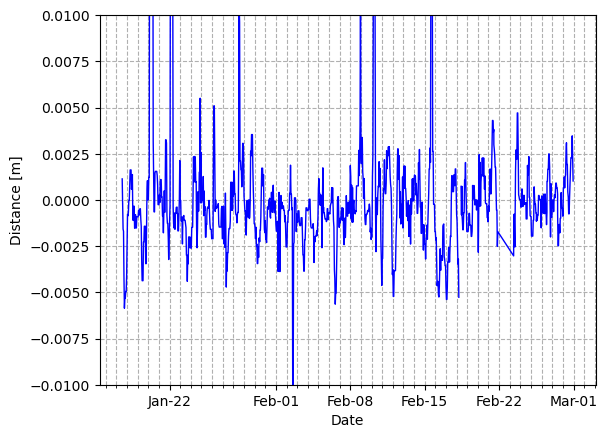

In [3]:
# apply temporal averaging
analysis.smoothed_distances = py4dgeo.temporal_averaging(analysis.distances, smoothing_window=6)

# load the smoothed distances
distances = analysis.smoothed_distances

# extract the time series at the selected core point
cp_sel_idx = 205840
ts_sel = distances[cp_sel_idx]

# plot the time series
plt.plot(timestamps[1:], ts_sel, c='blue', linewidth=1.0)

# format the date labels
dtFmt = mdates.DateFormatter('%b-%d') 
plt.gca().xaxis.set_major_formatter(dtFmt) 

# add plot elements
plt.xlabel('Date')
plt.ylabel('Distance [m]')
plt.ylim(-.01, .01)

# add grid with minor ticks every day
plt.grid(which='both', linestyle='--')
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))

plt.show()

The time series plot shows the M3C2 distance at a assumingly stable location, the paved path. The visualization shows that the values mostly vary within a range of 5 mm. Nonetheless, we can observe a fluctuating pattern, which follows a more or less daily course. 

We do not have external measurements available from the site, but we can assess the relation of the pattern to meteorological data recorded at the nearest regional weather station. Such data is openly provided in The Netherlands by [KNMI](https://dataplatform.knmi.nl/). For our analysis, you find the prepared file of the nearest station (Hoek van Holland, around 12 km away) with the course data (subdirectory `supplementary`). We read this data and add temperature information to the plot:

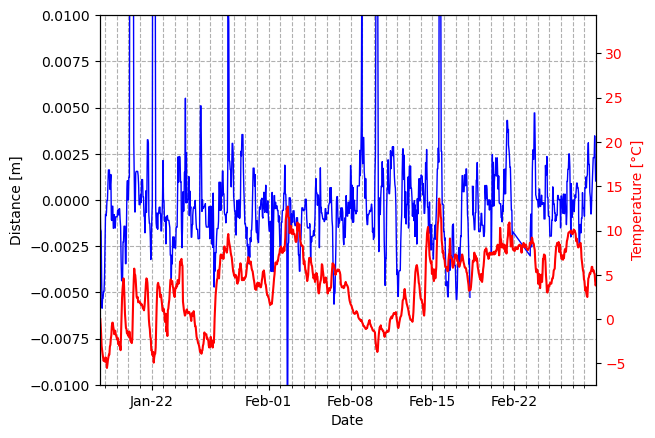

In [4]:
# read in the meteorological data
met = np.genfromtxt(f'{data_path}/supplementary/KNMI_201611_201705_hourly_330_hoekvanholland_formatted.txt',
                    delimiter=',', skip_header=1, encoding='utf-8',dtype='int')

# convert date string to datetime objects
met_dates = [datetime.strptime(d, '%Y%m%d') for d in met[:, 1].astype(str)]
# add hours to datetime objects
met_timestamps = [m + timedelta(hours=h) for m, h in zip(met_dates, met[:, 2].astype(float))]

# get the temperature values (and convert from 0.1 degrees Celsius to degrees Celsius)
temps = met[:, 7].astype(float) / 10

# plot the time series
plt.plot(timestamps[1:], ts_sel, c='blue', linewidth=1.0)

# format the date labels
dtFmt = mdates.DateFormatter('%b-%d') 
plt.gca().xaxis.set_major_formatter(dtFmt) 

# add plot elements
plt.xlabel('Date')
plt.ylabel('Distance [m]')
plt.ylim(-.01, .01)

# add grid with minor ticks every day
plt.grid(which='both', linestyle='--')
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))

# add temperature values to the plot on the right y-axis
ax2 = plt.twinx()
ax2.plot(met_timestamps, temps, color='red')
ax2.set_ylabel('Temperature [°C]')

# color the temperature y-axis components red
for tl in ax2.get_yticklabels():
    tl.set_color('red')
ax2.yaxis.label.set_color('red')

# limit the x-axis to the period of distance measurements
plt.xlim(timestamps[1], timestamps[-1])

plt.show()

The comparison shows that the fluctuation of distances coarsely follows the (inverse) course of temperatures. Mind that the point clouds are already aligned through rigid transformations derived for stable parts in the scene (cf. [theme 3 of this module](../03_3d_change_analysis/03_3d_change_analysis.ipynb) to revisit the approach). So we can observe an environmental influence on our measurements, which cannot be corrected by standard preprocessing procedures. We currently have no better way to correct these deviations - even though the effects of environmental influences are known, they cannot be modelled without extensive additional measurements (<a href="#references">Friedli et al., 2019</a>). 

For our analyses of the data, this means we need to be aware of such effects and handle them as uncertainty - to not misinterpret noise as surface change. To further reduce the effect of daily variations in subsequent analysis, we apply a temporal smoothing in a window of one week (cf. <a href="#references">Anders et al., 2019</a>).

In [5]:
# apply stronger temporal averaging (one week window)
analysis.invalidate_results(smoothed_distances=True)
analysis.smoothed_distances = py4dgeo.temporal_averaging(analysis.distances, smoothing_window=168)

[2023-04-13 11:11:05][INFO] Removing intermediate results from the analysis file I:\Projects\2020_ETRAINEE\Development\data_final\kijkduin_hourly/kijkduin_hourly.zip
[2023-04-13 11:11:05][INFO] Starting: Smoothing temporal data
[2023-04-13 11:37:26][INFO] Finished in 1580.3869s: Smoothing temporal data


<a id='volume-change-observation-depending-on-acquisition'></a>
## Volume change observation depending on acquisition frequency

From coastal dynamics, we know that morphological changes on a sandy beach are highly complex and take place at strongly varying magnitudes and rates. Having near-continuous 3D point clouds available, we can now look into the effect of temporal scales on our observation of surface dynamics. If sand is transported constantly to a local area and away from it, a reduced temporal acquisition interval implies that we are missing changes in our observation.

In our analysis object, we quantified the change (point cloud distances) for each epoch to the first epoch as global reference. So the change value at each epoch tell us the volume budget if only two acquisitions had been performed, at at the respective timespan from the epoch to the first epoch. The last epoch in our time series therefore correponds to an observation interval of six weeks.

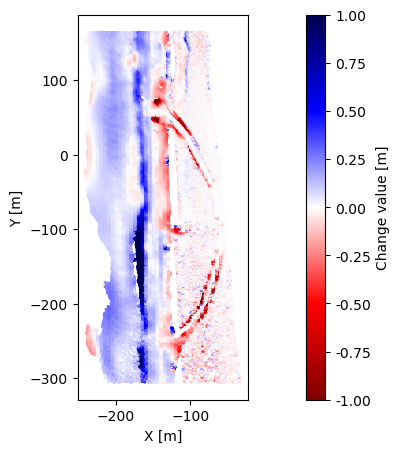

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

# get the change magnitude of the last epoch
change_vals = analysis.smoothed_distances[:, -1]

# plot coordinates colored by change values 
cloud = analysis.corepoints.cloud
d = ax.scatter(cloud[:,0], cloud[:,1], c = change_vals, cmap='seismic_r', vmin=-1.0, vmax=1.0, s=1)
ax.set_aspect('equal')
plt.colorbar(d, format=('%.2f'), label='Change value [m]', ax=ax)

# add plot elements
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

plt.show()

From the plot of changes at the end of the six-week period, we see overall surface increase of the beach. In the area of the pathway and at the foot of the dune, surface decrease is dominant. This surface decrease is caused by human modification, where sand was removed after a storm event (immediately before the onset of our time series data). Paths were therefore freed from sand, and this sand was deposited on the beach. You can see this deposition as attachment to the upper beach part in the linear structure of strong surface increase.

Now we can use the higher-frequency change information to find out how much surface changes, i.e. sand transport, we cannot see from this static six-week information. We only perform this for a sub-area on the beach, to exclude the influence of gaps in the data or vegetation on the dunes.

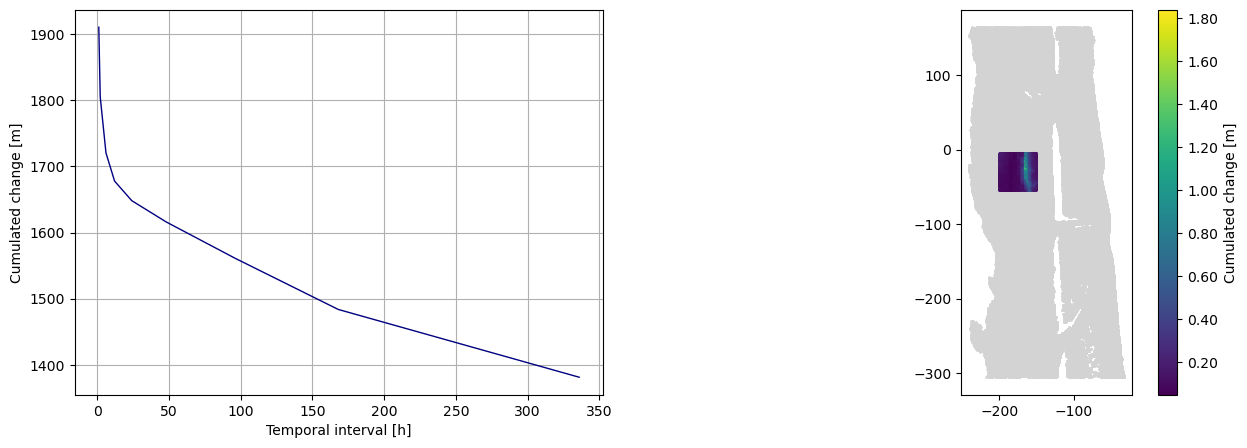

In [55]:
distances = analysis.smoothed_distances
coords = analysis.corepoints.cloud

# define a bounding box (here 50x50 m)
minx, miny = [-200.0, -55.0]
maxx, maxy = [-150.0, -5.0]

# select core points within the bounding box
cp_bb_idxs = np.where((coords[:, 0] > minx) & (coords[:, 0] < maxx) & (coords[:, 1] > miny) & (coords[:, 1] < maxy))

# select the corresponding time series
distances_bb = distances[cp_bb_idxs]

# loop over temporal intervals
tints = [1,2,6,12,24,48,96,168,336] # select temporal intervals in hours
cum_change_tint = []
for tint in tints:
    
    # select every nth time step, according to the temporal interval
    distances_tint = distances_bb[:,::tint]

    # get the change rate by subtracting the previous time step from the current time step
    distances_tint_diff = np.diff(distances_tint, axis=1)

    # calculate the cumulated change
    change_tint_cum = np.nansum(abs(distances_tint_diff), axis=1)
    cum_change_tint.append(np.sum(change_tint_cum))

    # store the cumulated change values at tint=1 for plotting
    if tint == 1:
        change_tint_cum_sel = change_tint_cum

# plot the cumulated change as a function of temporal interval and as map
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax1, ax2 = axs

ax1.plot(tints, cum_change_tint, c='navy', linewidth=1.0)

# make the y-axis logarithmic
#ax1.set_yscale('log')

# add plot elements
ax1.set_xlabel('Temporal interval [h]')
ax1.set_ylabel('Cumulated change [m]')
ax1.grid()

# plot the scene as background
ax2.scatter(cloud[:,0], cloud[:,1], c = 'lightgrey', s=1)

# plot the cumulated values as a map
d = ax2.scatter(coords[cp_bb_idxs,0], coords[cp_bb_idxs,1], c = change_tint_cum_sel, cmap='viridis', s=1)
ax2.set_aspect('equal')
plt.colorbar(d, format=('%.2f'), label='Cumulated change [m]', ax=ax2)

plt.show()

Above, we derive the cumulated (absolute) surface changes for a sub-area of 50 x 50 m. With increasing temporal interval, the plot shows a strong decrease in the total (positive and negative) surface change that can be observed. We see a particularly sharp decline from hourly to daily (i.e. 24-hourly) analysis. This gives us an indication that a large share of surface variability takes place at these timescales. However, we also need to bear in mind, that also noise is included in these observations. The smaller the temporal interval, the higher the influence of noise, which is present in each epoch of our change analysis.

In the map, you see the cumulated change for hourly temporal intervals in our sub-area. You could adapt the selected area (`cp_bb_idxs`) and see how it influences the result of this assessment, depending on the area on the beach and the processes that occurred there (stronger tidal influence, more/less anthropogenic modification, etc.) at different timescales. Also vary the temporal interval of the visualized cumulated change (`change_tint_cum_sel`). How does the spatial variation change and what does it tell you about the timescales of observed surface activities?

<a id='analysis-of-coastal-dynamics-with-time-series-based-change-analysis'></a>
## Analysis of coastal dynamics with time series-based change analysis

As you know from previous themes, the dense temporal data provided by 4D point clouds holds potential for new insights on surface processes. Special [methods](../04_3d_timeseries_analysis/04_3d_timeseries_analysis.ipynb) are being developed to leverage the time series information. Due to the complex surface dynamics induced by variable sand transport, sandy beaches have been an important use case for such method developments. In the following, we will look into the assessment of coastal change patterns via time series clustering, and the characterization of surface activities with 4D objects-by-change and self-organizing maps (SOMs).

<a id='coastal-change-patterns'></a>
### Coastal change patterns

In the data exploration and analysis so far, we could already observe different processes taking place on the beach. Now, we are going to look into characteristic change patterns that can be observed on Kijkduin beach using time series clustering following <a href="#references">Kuschnerus et al. (2021)</a>. The approach is explained in a [previous theme](../04_3d_timeseries_analysis/04_3d_timeseries_analysis.ipynb).

In [ ]:
# import kmeans clustering module from scikit-learn
from sklearn.cluster import KMeans

# use the smoothed distances for clustering
distances = analysis.smoothed_distances

# define the number of clusters
ks = [10]

# create an array to store the labels
labels = np.full((distances.shape[0], len(ks)), np.nan)

# perform clustering for each number of clusters
for kidx, k in enumerate(ks):
    print(f'Performing clustering with k={k}...')
    nan_indicator = np.logical_not(np.isnan(np.sum(distances, axis=1)))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(distances[nan_indicator, :])
    labels[nan_indicator, kidx] = kmeans.labels_

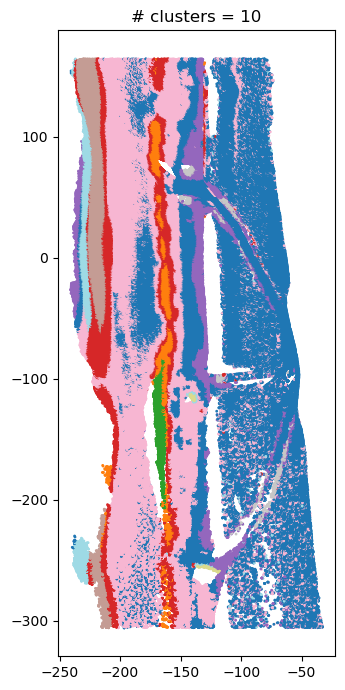

In [58]:
# plot the cluster labels as a map
fig, ax = plt.subplots(1,1, figsize=(7,7))

cmap_clustering = 'tab20'
sc1 = ax.scatter(cloud[:,0],cloud[:,1],c=labels[:,0],cmap=cmap_clustering,s=1, label=ks[0])

ax.set_aspect('equal')
ax.set_title(f'# clusters = {ks[0]}')

plt.tight_layout()
plt.show()

The obtained clusters can then be related to knowledge about processes on the beach - for example the formation of intertidal bars. As this is an unsupervised method, also processes with a-priori unknown occurrence may be revealed. In this case, one can further look into the time series and properties of surface behaviour, as well as the location on the beach and spatial patterns, to derive an explanation for the observed pattern. 

Based on time series clustering at Kijkduin beach, <a href="#references">Kuschnerus et al. (2021)</a> have uncovered a set of specific processes represented by each cluster, among them anthropogenic modifications through bulldozer works and tidal erosion. The dune area is largely assigned to the same cluster due to the moving vegetation cover as common surface property.
_Note that the results differ from our analysis above due to a different timespan and temporal resolution being analyzed in their publication._

<center>
<img src="media/m3_casestudy_beach_kuschnerus_patterns.png" alt="kijkduin_changepatterns" title="Change patterns derived for Kijkduin" width="650">

<i>Change patterns identified from time series clustering (number of clusters = 10) for a laser scanning time series at Kijkduin beach. Figure by <a href="https://doi.org/10.5194/esurf-9-89-2021">Kuschnerus et al. (2021)</a> / [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).</i>
</center>

Beyond the identification of processes from change patterns, the analysis provides information to analysts, for example, as to how to partition the scene into areas of specific relevance. For coastal monitoring, it may be of particular interest in which areas human activities interact with natural sand transport - so that in-depth observation can be performed, or even measures could be taken.

<a id='characterization-of-morphological'></a>
### Characterization of morphological surface activities

For the identification of individual surface activities in near-continuous 3D time series, you have learnt about the [extraction of 4D objects-by-change in a previous theme], following <a href="#references">Anders et al. (2021)</a>. Since the method is computationally expensive (long processing time), we will not interactively run the full analysis. Just as a reminder of the process, let's extract an example object at a selected location on the beach:

In [59]:
# select a core point to use as seed
cp_idx_sel = 15162

# parametrize the 4D-OBC extraction
algo = py4dgeo.RegionGrowingAlgorithm(window_width=14, 
                                      minperiod=2, 
                                      height_threshold=0.05, 
                                      neighborhood_radius=1.0,
                                      min_segments=10, 
                                      thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                                      seed_candidates=[cp_idx_sel])

# run the algorithm
analysis.invalidate_results(seeds=True, objects=True, smoothed_distances=False) # only required if you want to re-run the algorithm
objects = algo.run(analysis)

[2023-04-13 14:54:49][INFO] Removing intermediate results from the analysis file I:\Projects\2020_ETRAINEE\Development\data_final\kijkduin_hourly/kijkduin_hourly.zip
[2023-04-13 14:54:49][INFO] Starting: Find seed candidates in time series
[2023-04-13 14:54:49][INFO] Finished in 0.0116s: Find seed candidates in time series
[2023-04-13 14:54:49][INFO] Starting: Sort seed candidates by priority
[2023-04-13 14:54:49][INFO] Finished in 0.0642s: Sort seed candidates by priority
[2023-04-13 14:54:49][INFO] Starting: Performing region growing on seed candidate 1/1
[2023-04-13 14:55:19][INFO] Finished in 30.3813s: Performing region growing on seed candidate 1/1


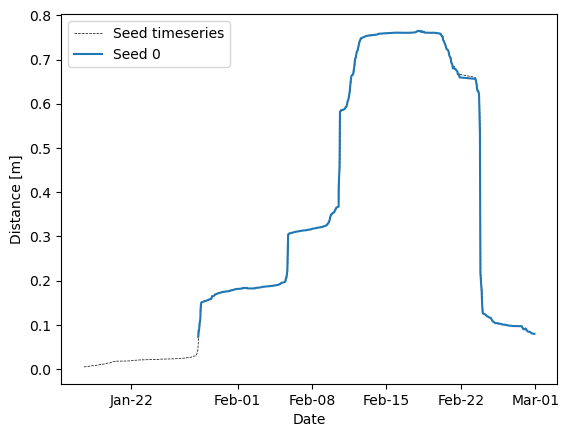

In [61]:
seed_timeseries = analysis.smoothed_distances[cp_idx_sel]
plt.plot(timestamps[1:],seed_timeseries, c='black', linestyle='--', linewidth=0.5, label='Seed timeseries')

for sid, example_seed in enumerate(analysis.seeds):
    seed_end = example_seed.end_epoch
    seed_start = example_seed.start_epoch
    seed_cp_idx = example_seed.index

    plt.plot(timestamps[seed_start:seed_end+1], seed_timeseries[seed_start:seed_end+1], label=f'Seed {sid}')

# format the date labels
dtFmt = mdates.DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)

# add plot elements
plt.xlabel('Date')
plt.ylabel('Distance [m]')

plt.legend()
plt.show()

Above we see the time series of a selected location, where temporary surface increase and decrease - representing a sand bar - was detected as seed. We visualize the corresponding 4D object-by-change, i.e. the time series of all locations belonging to the object and its spatial extent in the scene:

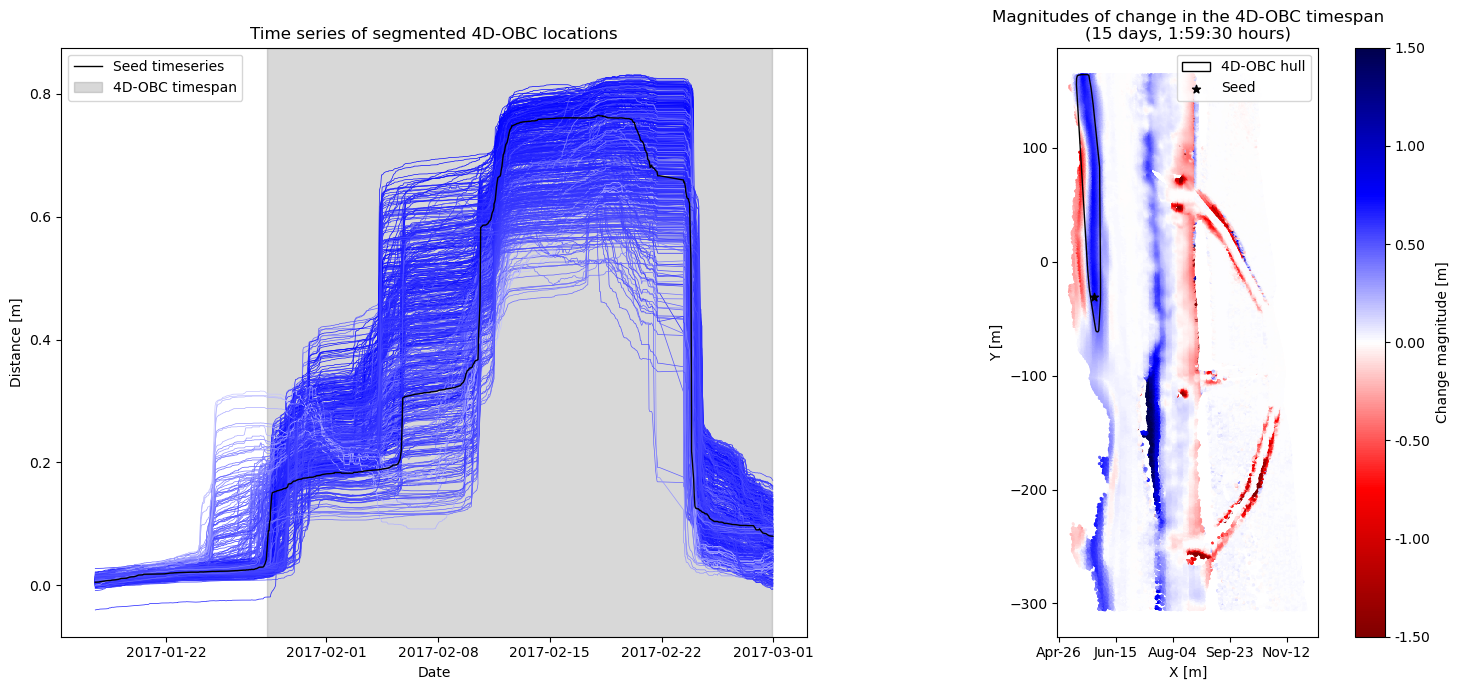

In [65]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
ax1,ax2 = axs

# get indices of 4D-OBC
sel_seed_idx = 0
idxs = objects[sel_seed_idx].indices

# get change values at end of object for each location
epoch_of_interest = int((objects[sel_seed_idx].end_epoch - objects[sel_seed_idx].start_epoch)/2 + objects[sel_seed_idx].start_epoch)
distances_of_interest = analysis.smoothed_distances[:, epoch_of_interest]

# get the change magnitude between end and start of object for each location
magnitudes_of_interest = analysis.smoothed_distances[:, epoch_of_interest] - analysis.smoothed_distances[:, int(objects[sel_seed_idx].start_epoch)]

# set the colormap according to magnitude at each location in the object
crange = 1.5
import matplotlib.colors as mcolors
cmap = plt.get_cmap('seismic_r').copy()
norm = mcolors.CenteredNorm(halfrange=crange)
cmapvals = norm(magnitudes_of_interest)

# plot the timeseries of the segmented locations (colored by time series similarity)
for idx in idxs[::10]:
    ax1.plot(timestamps[1:], analysis.smoothed_distances[idx], c=cmap(cmapvals[idx]), linewidth=0.5)

# plot the seed time series
ax1.plot(timestamps[1:], analysis.smoothed_distances[cp_idx_sel], c='black', linewidth=1., label='Seed timeseries')

# fill the area of the object
ax1.axvspan(timestamps[objects[sel_seed_idx].start_epoch], timestamps[objects[sel_seed_idx].end_epoch], alpha=0.3, color='grey', label='4D-OBC timespan')

# add legend and format the date labels
dtFmt = mdates.DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)
ax1.legend()

# get subset of core points incorporated in 4D-OBC
cloud = analysis.corepoints.cloud
subset_cloud = cloud[idxs,:2]

# plot coordinates colored by change values at end magnitude of object
d = ax2.scatter(cloud[:,0], cloud[:,1], c = magnitudes_of_interest, cmap='seismic_r', vmin=-crange, vmax=crange, s=1)
plt.colorbar(d, format=('%.2f'), label='Change magnitude [m]', ax=ax2)
ax2.set_aspect('equal')

# plot convex hull of 4D-OBC
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
hull = ConvexHull(subset_cloud)
ax2.add_patch(Polygon(subset_cloud[hull.vertices,0:2], label = '4D-OBC hull', fill = False))

# plot seed location of 4D-OBC
ax2.scatter(cloud[cp_idx_sel,0], cloud[cp_idx_sel,1], marker = '*', c = 'black', label = 'Seed')

# add plot elements
ax1.set_title('Time series of segmented 4D-OBC locations')
ax1.set_xlabel('Date')
ax1.set_ylabel('Distance [m]')
ax2.set_title(f'Magnitudes of change in the 4D-OBC timespan\n({timestamps[epoch_of_interest]-timestamps[analysis.objects[sel_seed_idx].start_epoch]} hours)')
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

This sandbar object is only one example of a surface activity on the beach. There may be more occurrences of sand bars at another location along the beach, and also in the same area during another time span. The automatic spatiotemporal segmentation can be applied to the full dataset to extract all occurrences. The full analysis of the 4D point clouds in Kijkduin (hourly data for six months) is performed in <a href="#references">Anders et al. (2021)</a>. As a result, 2,021 4D objects-by-change were identified, all representing a surface activity of temporary deposition or erosion.

This analysis can be used to assess the occurrence of specific processes. If we have knowledge about the expected properties, such as a sand bar, the objects can be filtered for these and analyzed with respect to their spatiotemporal characteristics, as well as links to external drivers (e.g., tidal information or storms).

The full results of 4D objects-by-change of Kijkduin beach was used by <a href="#references">Hulskemper et al. (2021)</a> in an unsupervised clustering to automatically assess groups of surface activities. For this, self-organizing maps (SOMs; <a href="#references">Kohonen, 1990</a>) are used, a method that can preserve topological order to groups (unlike k-means, or other methods, where the clusters are unrelated). In the resulting SOM, we can therefore also obtain information on neighboring clusters in feature space. This is an advantage for our use case, as the border between objects - i.e. the characteristics of surface processes - are not sharp, and we may be interested in variations of similar (neighboring) clusters. Look into the paper by <a href="#references">Hulskemper et al. (2021)</a> to learn more about the method with specific application to 4D objects-by-change of the sandy beach.

Here, we will look into the results of their analysis, where different spatial and temporal features were used to obtain groups of similar 4D objects-by-change - among them the spatial extent, the cross-shore position on the beach (a case study-specific feature), magnitude, and duration of change.

<center>
<img src="media/m3_casestudy_beach_hulskemper_som.png" alt="kijkduin_som" title="SOM of surface activities" width="800">

<i> A) Visualization of a self-organizing map (SOM) for erosion objects. Each plot represents a SOM node with one group of surface activities. The x-axis of each plot
represents the mean duration of the 4D objects-by-change (4D-OBCs) in the node. The y-axis of each plot represents the mean height
change of the 4D-OBCs in the node. The background colors represent the mean segment size per node
(on a logarithmic scale). B) Spatial extent of the 4D-OBCs found in the nodes inside the blue polygon in A. C) Seed time series and timing of the 4D-OBCs in B. Figure by <a href="https://doi.org/10.5194/isprs-archives-XLVIII-2-W2-2022-53-2022">Hulskemper et al. (2022)</a> / [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).</i>
</center>


The SOM renders the grouping of surface activities visually interpretable. For example, we can see a clear sorting of objects according to their duration, and partly also for the spatial extent. Differences between nodes (i.e. groups) are fairly gradual and not distinct in the visual representation. There are a also a few nodes that seem more exceptional from their neighbors (E(h,c), E(h,d), and E(a,h)), with fairly instantaneous or step-like surface actcivities with a large magnitude (down to -1.5 m). The 4D objects-by-change represented by E(a,h) are distinguishable from the others by their shorter duration.

The nodes that are marked by the blue rectangle (subfigure A) are identified as activities related to the intertidal zone of the beach, i.e. erosion of sand in proximity to sand bar formation. Their location is visualized in the map (subfigure B). The time series of these objects (subfigure C) show that they all have similar change behaviour during their existence, even if the timing and duration may be different.

In this way, the SOM approach allows identifying groups of surface activities with similar spatiotemporal characteristics, without needing to define them beforehand. Using this, it is also possible to look for a certain type of surface activity, and deriving other occurrences of the same behavior - ultimately relating to occurrences of the same underlying process. For further assessment of beach dynamics, it is possible to relate the occurrence of a type of surface activity to external drivers. This could be, for example, a relation to strong wind events or high tides using respective records from nearby stations. The time series analysis of high-resolution topographic data at the beach thereby holds potential to strongly further our understanding of surface processes and their driving mechanisms. For the application, this provides a powerful tool in the planning of sustainable measures to maintain the coast and mitigating ongoing erosion.

<a id='variation-of-beach-width'></a>
## Variation of beach width (Noordwijk)

Zooming out again from the individual surface activities induced by different processes, a relevant variable to observe at the coast is the variation of beach width. Beach width is defined as a _coastal state indicator_ (<a href="#references">Van Koningsveld et al., 2005</a>). To derive it from high-frequency laser scanning time series, <a href="#references">Kuschnerus et al. (2023)</a> have leveraged a property of LiDAR acquisitions: there is no surface representation (i.e. measurements), where the beach is covered by water. This area varies of course with the tides, so it is especially interesting to consider the temporal variability but also long-term evolution of beach width from the near-continuous, permanent laser scanning acquisition. The presented study was conducted at Noordwijk beach, another site of the [CoastScan](https://coastscan.citg.tudelft.nl/) project.

For the analysis, the authors grid the point clouds to digital elevation models (DEMs) and determine how far seawards the beach surface is covered by data. This provides an assessment of the shoreline. Beach width is then derived as the distance from this shoreline to the foot of the dunes. Due to the special setting of permanent laser scanning, and the perpendicular orientation of the beach scene to the scanner origin, the dune foot line along the shore can be determined as a fixed X coordinate in the local coordinate system:

<center>
<img src="media/m3_casestudy_beach_kuschnerus_beachwidth.png" alt="beach_width" title="Assessment of beach width" width="650">

<i>Analysis of beach width using terrestrial laser scanning point clouds by deriving the shoreline from the border between surface representation and no data (area covered by water). Near-continuous acquisition provides insight into the temporal variability of beach width within tidal cycles and throughout longer-term monitoring. Beach width is marked with orange points where the waterline matches the high and low tides according to records of the Dutch Ministry of Infrastructure and Water Management _Rijkswaterstaat_. Figures by <a href="http://doi.org/10.4995/JISDM2022.2022.13729">Kuschnerus et al. (2022)</a> / [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).</i>
</center>

According to their results (<a href="#references">Kuschnerus et al., 2023</a>), beach width varies between 150 m and 250 m, and the observation fits the official records of high and low tides in their timing in many (but not all) cases (around 60 %). This is owed to the situation that missing data at the shoreline can be caused by several factors, not only water cover from the sea. For example, during storm and precipitation, the range of the laser scanner is impeded and causes the effect of missing data towards the sea - which misinterprets the shoreline in the presented approach. Vice versa, reflections from turbulent waves may lead to measurements from the water surface (artifacts in the topographic representation). The beach width will be overestimated in such cases.

Apart from possible improvements in the analysis, the assessment of beach width at the local scale and with the high temporal resolution of hourly laser scanning provides a valuable, new scale of monitoring the coastal state.

**Your turn**: You can use a similar approach to assess the beach width for our Kijkduin use case. How? Visually determine the cross-shore location of the dune foot (X coordinate). Then for each epoch in the `SpatiotemporalAnalysis` object, determine the points furthest seaward which have at least n neighbors (try n=10, following <a href="#references">Kuschnerus et al. (2023)</a>). You know this spatial neighborhood search from [theme 2 of this module](../02_pointcloud_programming_python/02_pointcloud_programming_python.ipynb). To assess variability, you can compare the beach width for several hours within a day or week. To assess a longer-term evolution, compare beach width, e.g., at the beginning and end of the available time series (here six weeks). Do you see a similar result as for Noordwijk? How does the beach width behave in Kijkduin?

<a id='spatiotemporal-variation-of-surface-moisture-on-the-beach'></a>
## Spatiotemporal variation of surface moisture on the beach

So far, we have mainly made use of the topographic, i.e. geometric, information provided with our 4D laser scanning point clouds. Thinking back of [theme 1](../01_pointcloud_principles/01_pointcloud_principles.md), there are other LiDAR attributes we can make use of for analysis - notably the backscatter information. For coastal monitoring, the laser return intensity has been used by <a href="#references">Jin et al. (2021)</a> to assess variation in surface moisture. With all other factors (e.g. range and incidence angle) constant, the variability of moisture of the target surface is directly expressed in the intensity of the returned signal with acquisitions repeated from a fixed position. Of course the other factors are not perfectly constant, and especially variable across the scene. The authors have accounted for this by deriving a model for the derivation of surface moisture from the intensity signal (look into <a href="#references">Jin et al. (2021)</a>).

The results of this assessment show that surface moisture on the beach is linked to the topography, with higher parts of the beach being dryer (at the surface). This can be related to retreat of the tides, where upper parts have more time for drying through evaporation that areas closer to the shoreline. It is also possible to trace the transition from shallow water-covered areas to water-free parts on the beach through their moisture signal.

With the available 4D point clouds (here of a beach in Belgium, the assessment has not been performed for Kijkduin), it is now possible to observe surface moisture dynamics at high spatial and temporal resolution. This provides a quantified assessment of tidal fluctuation of surface conditions on the beach. At this observation scale, it was further possible to reveal a relation of surface moisture variation to anthropogenic disturbance, such as tire tracks of vehicles (<a href="#references">Jin et al. 2021</a>). This kind of information can be used for completely new assessments of the human-environment interaction in a beach environment. Further, the spatially extensive and temporally dense information on surface moisture can help to improve models on aeolian sand transport, which can only occur under certain surface conditions (which were difficult to measure at the appropriate spatiotemporal scale with other survey strategies).

<a id='correlation-with-SAR'></a>
## Correlation with SAR

As a last aspect of this case study - and also this module - we take a look at the bridge from the close spatial scale of our 4D point clouds to larger-scale observations, as are available from satellite remote sensing. Permanent laser scanning at Noordwijk (a [CoastScan](https://coastscan.citg.tudelft.nl/) site) has provided a pioneer case study to look into a combination with space-borne Synthetic Aperture Radar (SAR) images, presented by <a href="#references">Di Biase et al. (2022)</a>. SAR provides an active remote sensing method with special advantages for assessing ground surface characteristics. In their study, <a href="#references">Di Biase et al. (2022)</a> specifically assess surface roughness in its temporal variability, in relation to wind speed and direction influencing the backscatter behavior. Intensity of the signal was then used as variable to assess the correlation between SAR and near-continuous TLS.

The presented study area of 4D point clouds is covered by 12 pixels of Sentinel-1 data obtained from Google Earth Engine in the same period as the permanent laser scanning acquisitions. Therefore, the 4D point clouds are spatially aggregated to the information contained within each of these pixels. Results show a positive correlation between the 4D point cloud data and SAR signal under low wind speeds, though correlation is overall not too high (up to 0.5). Under strong wind conditions (>8 m/s), irregular and low correlations (positive and negative) are derived. This can be related to drier sand under strong winds, which increases the laser return intensity of the dry and hence highly reflective surface (<a href="#references">Di Biase et al., 2022</a>).

Although presented as preliminary study, the study shows the potential of directing the observation of a complex system to a combination of different spatiotemporal scales - as is required by the broad range of spatiotemporal scales on which processes of sand transport occur. In this context, repeat SAR aquisitions provide a promising Earth observation product to relate local observations at sites like Kijkduin and Noordwijk to larger regions and entire coastlines.

As participants of this course, you are becoming experts on a broad set of Earth observation strategies (data and methods). So you may use your gained combined knowledge develop new ideas for investigating complex natural systems and human-environment interaction through time series analysis!

<a id='references'></a>
## References

* Anders, K., Lindenbergh, R. C., Vos, S. E., Mara, H., de Vries, S., & Höfle, B. (2019). High-Frequency 3D Geomorphic Observation Using Hourly Terrestrial Laser Scanning Data Of A Sandy Beach. ISPRS Ann. Photogramm. Remote Sens. Spatial Inf. Sci., IV-2/W5, pp. 317-324. doi: [10.5194/isprs-annals-IV-2-W5-317-2019](https://doi.org/10.5194/isprs-annals-IV-2-W5-317-2019).
* Anders, K., Winiwarter, L., Mara, H., Lindenbergh, R., Vos, S. E. & Höfle, B. (2021). Fully automatic spatiotemporal segmentation of 3D LiDAR time series for the extraction of natural surface changes. ISPRS Journal of Photogrammetry and Remote Sensing, 173, pp. 297-308. doi: [10.1016/j.isprsjprs.2021.01.015](https://doi.org/10.1016/j.isprsjprs.2021.01.015).
* Di Biase, V., Kuschnerus, M. & Lindenbergh, R. (2022). Permanent Laser Scanner and Synthetic Aperture Radar data: correlation characterization at a sandy beach, Sensors, 22(6), 2311 doi: [10.3390/s22062311](https://doi.org/10.3390/s22062311).
* Friedli, E., Presl, R., & Wieser, A. (2019). Influence of atmospheric refraction on terrestrial laser scanning at long range. 4th Joint International Symposium on Deformation Monitoring: JISDM, pp. 6.
* Hulskemper, D., Anders, K., Antolínez, J.A.Á., Kuschnerus, M., Höfle, B. & Lindenbergh, R. (2022). Characterization of morphological surface activities derived from near-continuous terrestrial LiDAR time series. Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLVIII-2/W2-2022, pp. 53–60. doi: [10.5194/isprs-archives-XLVIII-2-W2-2022-53-2022](https://doi.org/10.5194/isprs-archives-XLVIII-2-W2-2022-53-2022).
* Jin, J., Verbeurgt, J., De Sloover, L., Stal, C., Deruyter, G., Montreuil, A.-L., Vos, S., De Maeyer, P. & De Wulf, A. (2021). Monitoring spatiotemporal variation in beach surface moisture using a long-range terrestrial laser scanner. ISPRS Journal of Photogrammetry and Remote Sensing, 173, pp. 195-208. doi: [10.1016/j.isprsjprs.2021.01.011](https://doi.org/10.1016/j.isprsjprs.2021.01.011).
* Kohonen, T. (1990): The Self-Organizing Map. Proceedings of the IEEE, 78(9), pp. 1464–1480.
* Kuschnerus, M., Schröder, D. & Lindenbergh, R. (2021). Environmental influences on the stability of a permanently installed laser scanner. Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLIII-B2-2021, pp. 745–752. doi: [10.5194/isprs-archives-XLIII-B2-2021-745-2021](https://doi.org/10.5194/isprs-archives-XLIII-B2-2021-745-2021).
* Kuschnerus, M., Lindenbergh, R. & Vos, S. (2021). Coastal Change Patterns from Time Series Clustering of Permanent Laser Scan Data. Earth Surface Dynamics, 9, pp. 89–103. doi: [10.5194/esurf-9-89-2021](https://doi.org/10.5194/esurf-9-89-2021).
* Kuschnerus, M., Lindenbergh, R., Lodder, Q., Brand, E. & Vos, S. (2022). Detecting anthropogenic volume changes in cross sections of a sandy beach with permanent laser scanning. Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLIII-B2-2022, pp. 1055–1061. doi: [10.5194/isprs-archives-XLIII-B2-2022-1055-2022](https://doi.org/10.5194/isprs-archives-XLIII-B2-2022-1055-2022).
* Kuschnerus, M., Lindenbergh, R. & de Vries, S. (2022): Assessing sandy beach width variations on intertidal time scales using permanent laser scanning. Proceedings of 5th Joint International Symposium on Deformation Monitoring (JISDM), Valencia. doi: [10.4995/JISDM2022.2022.13729](http://doi.org/10.4995/JISDM2022.2022.13729).
* Van Koningsveld, M., Davidson, M.A., & Huntley, D.A. (2005). Matching Science with Coastal Management Needs: The Search for Appropriate Coastal State Indicators. Journal of Coastal Research, pp. 399–411.
* Vos, S., Anders, K., Kuschnerus, M., Lindenbergh, R., Höfle, B., Aarninkhof, S., & de Vries, S. (2022). A high-resolution 4D terrestrial laser scan dataset of the Kijkduin beach-dune system, The Netherlands. Scientific Data, 9 (1), pp. 191. doi: [10.1038/s41597-022-01291-9](https://doi.org/10.1038/s41597-022-01291-9).